In [3]:
# import from script
from diedfunctions import * # 'Kernel restart & clear output' to load new functions
import os
import time

In [40]:
lemmatize??

In [ ]:
# textfile = f'../../../enwiki_city_pairs/paris_milan.txt'

# with open(textfile, 'r', encoding='utf-16') as f:
#     parismilan = [x.strip() for x in f.read().split('\n') if len(x) and 'title=' not in x]
    
# parismilan[:10]

In [5]:
directory = f'../../../enwiki_city_pairs/'
city_pairs_text = []

for file in os.listdir(directory):
    if file.endswith('.txt'):
        with open(directory+file, encoding='utf-16') as f:
            city_pair_text = ' '.join([x.strip() for x in f.read().split('\n') if len(x) and 'title' not in x])
            city_pairs_text.append(city_pair_text)

In [2]:
# city_pairs_text[7]

In [5]:
texts = city_pairs_text
nlp.max_length = 1500000
processed_text = [text for text in tqdm(nlp.pipe(texts, n_process=-1, disable=["ner", "parser"]), total=len(texts))]
lemmatized_text = [[word.lemma_.lower() for word in text if word.pos_ in POSfilter and not word.is_punct and not word.is_stop] for text in processed_text]
regexed_text = [[re.sub(r'\W+', '', word) for word in text] for text in lemmatized_text]

  0%|          | 0/10 [00:00<?, ?it/s]

NameError: name 'POSfilter' is not defined

In [41]:
%%time

lemmatized_texts = lemmatize(city_pairs_text, POSfilter=['PROPN'])

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: total: 9.42 s
Wall time: 1min 49s


In [42]:
%%time

dictionary, corpus = vectorize(lemmatized_texts)

CPU times: total: 438 ms
Wall time: 457 ms


In [52]:
from gensim.models.wrappers import LdaMallet
from gensim.models import CoherenceModel
PATH_TO_MALLET = r'C:/mallet/bin/mallet.bat'

def train_model(lemmatized_text, dictionary=[], corpus=[], MIN_DF = 10, MAX_DF = 0.6, N_TOPICS = 10, N_ITERATIONS = 1000):
    # usually 1000 iterations will do
    
#     # Call vectorization function if either dictionary or corpus is missing as parameter
#     if not type(dictionary) == gensim.corpora.dictionary.Dictionary or not corpus:
#         dictionary, corpus = vectorize(lemmatized_text, MIN_DF, MAX_DF)
    
    
    lda_model = LdaMallet(PATH_TO_MALLET,
                corpus=corpus,
                id2word=dictionary,
                num_topics=N_TOPICS,
                optimize_interval=10,
                iterations=N_ITERATIONS)
    
    coherence_score = CoherenceModel(model=lda_model, texts=lemmatized_text, dictionary=dictionary, coherence='c_v').get_coherence()
    
    return(lda_model, coherence_score, dictionary, corpus)

In [53]:
lda_model, coherence_score, dictionary, corpus = train_model(lemmatized_texts, dictionary, corpus, N_TOPICS=7)

In [54]:
coherence_score

0.5386336483113267

In [55]:
MAX_WORDS = 20
N_TOPICS = 7

for i in range(N_TOPICS):
    words = lda_model.show_topic(i, topn=MAX_WORDS)
    print([(x[0], round(x[1], 3)) for x in words])

[('film', 0.007), ('henderson', 0.005), ('hitler', 0.004), ('mario', 0.004), ('kart', 0.004), ('central', 0.003), ('games', 0.003), ('soviet', 0.003), ('olympics', 0.003), ('olympic', 0.003), ('mr', 0.003), ('nazi', 0.002), ('greece', 0.002), ('professor', 0.002), ('czechoslovakia', 0.002), ('minister', 0.002), ('queen', 0.002), ('zoo', 0.002), ('turkey', 0.002), ('lord', 0.002)]
[('eurostar', 0.004), ('review', 0.003), ('ballet', 0.003), ('goupil', 0.003), ('department', 0.003), ('empire', 0.003), ('benjamin', 0.003), ('parliament', 0.003), ('mary', 0.003), ('company', 0.003), ('joyce', 0.002), ('gaulle', 0.002), ('burroughs', 0.002), ('françois', 0.002), ('times', 0.002), ('musée', 0.002), ('crowley', 0.002), ('pompidou', 0.002), ('wilde', 0.002), ('chris', 0.002)]
[('oxford', 0.004), ('stock', 0.004), ('rugby', 0.003), ('ottoman', 0.003), ('piano', 0.002), ('bernhardt', 0.002), ('bailey', 0.002), ('ray', 0.002), ('coventry', 0.002), ('margaret', 0.002), ('scott', 0.002), ('norton', 

c:\users\deejay\personal files [local]\applied data science\thesis - citynet\citynet\venv_citynet\lib\site-packages\wordcloud\wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
c:\users\deejay\personal files [local]\applied data science\thesis - citynet\citynet\venv_citynet\lib\site-packages\wordcloud\wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
c:\users\deejay\personal files [local]\applied data science\thesis - citynet\citynet\venv_citynet\lib\site-packages\wordcloud\wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
c:\users\deejay\personal files [local]\app

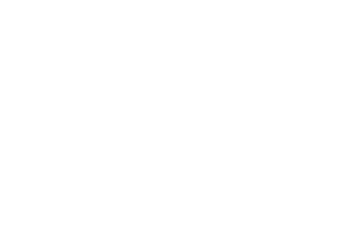

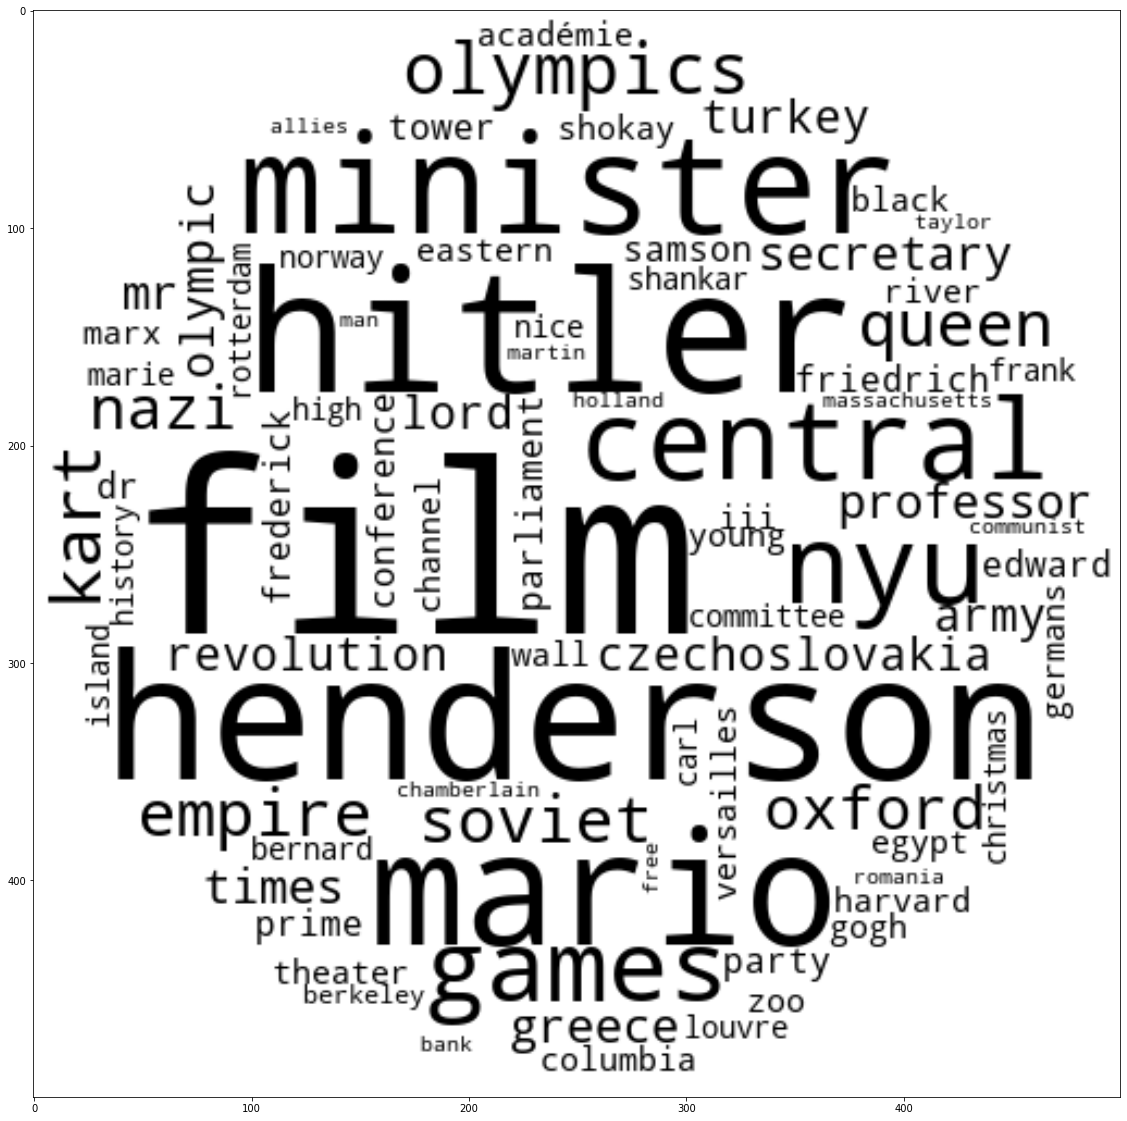

In [48]:
from wordcloud import WordCloud, STOPWORDS
import requests
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image

def black_circle():
    response = requests.get('https://i.ibb.co/kHNWRYD/black-circle-better.png')
    circle_mask = np.array(Image.open(BytesIO(response.content)))
    return circle_mask 

circle_mask = black_circle()

wordcloud = WordCloud(background_color='#fff',
                    color_func=lambda *args, **kwargs: (0,0,0),
                     mask=circle_mask)
wordcloud.generate_from_frequencies(frequencies=dict(lda_model.show_topic(1, 80)))
plt.axis("off")
plt.figure(figsize=(20, 20))
plt.imshow(wordcloud, interpolation="bilinear")

In [56]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import gensim

pyLDAvis.enable_notebook()

# dictionary, corpus = vectorize(lemmatized_text, MIN_DF=1, MAX_DF=0.6)
# model, coherence, dictionary, corpus = train_model(lemmatized_text=lemmatized_text, dictionary=[], corpus=[], N_TOPICS=4)

lda_conv = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda_model)
gensimvis.prepare(lda_conv, corpus, dictionary)


c:\users\deejay\personal files [local]\applied data science\thesis - citynet\citynet\venv_citynet\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
c:\users\deejay\personal files [local]\applied data science\thesis - citynet\citynet\venv_citynet\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
c:\users\deejay\personal files [local]\applied data science\thesis - citynet\citynet\venv_citynet\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.106020 -0.093675       1        1  34.499226
1     -0.086909 -0.033664       2        1  18.864977
3      0.061356 -0.044690       3        1  14.184153
4      0.062674 -0.059624       4        1  14.175510
5     -0.176404 -0.198318       5        1   7.385573
2     -0.142592  0.392367       6        1   6.250220
6      0.387894  0.037603       7        1   4.640342, topic_info=           Term        Freq       Total Category  logprob  loglift
3345        nyu  115.000000  115.000000  Default  30.0000  30.0000
5619       uefa   37.000000   37.000000  Default  29.0000  29.0000
1869       film  122.000000  122.000000  Default  28.0000  28.0000
7227      silva   26.000000   26.000000  Default  27.0000  27.0000
899      ballet   64.000000   64.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
5494  rigoletto    7.896279   40.298486   Topic7  -5.6140   1.4405
5223       josé    5.922210   15.029434   Topic7  -5.9017   2.1391
5015       dior    5.922210   16.050091   Topic7  -5.9017   2.0734
941      battle    5.922210   19.194199   Topic7  -5.9017   1.8945
2319   hospital    5.922210   31.497624   Topic7  -5.9017   1.3992

[644 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
9287       2  0.988879         0
9288       2  0.988879      10th
9289       6  1.021306     131st
597        5  1.020397      1491
9295       2  0.988879    192431
...      ...       ...       ...
5674       4  0.922314  zentropy
4760       1  1.003266       zoo
6853       4  0.365056      özil
6853       7  0.638847      özil
15041      2  0.988879    ʻabdul

[998 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 5, 6, 3, 7])

In [51]:
import pandas as pd

transformed_docs = lda_model.load_document_topics()
topic_distributions = pd.DataFrame([[x[1] for x in doc] for doc in transformed_docs], 
             columns=['topic_{}'.format(i) for i in range(7)])
topic_distributions.head(12)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
0,0.000144,0.000224,0.000014,0.000043,0.000015,0.999545,0.000014
1,0.001215,0.661096,0.335006,0.002405,0.000001,0.000277,0.000001
2,0.941184,0.058738,0.000006,0.000018,0.000006,0.000041,0.000006
3,0.001405,0.036703,0.000005,0.000014,0.000005,0.961863,0.000005
4,0.945998,0.053834,0.000013,0.000039,0.000013,0.000090,0.000013
5,0.999723,0.000151,0.000010,0.000029,0.000010,0.000067,0.000010
6,0.000015,0.614048,0.000002,0.385922,0.000002,0.000010,0.000002
7,0.026032,0.369643,0.000002,0.389950,0.052603,0.161772,NaN
8,0.954281,0.045659,0.000005,0.000014,0.000005,0.000032,0.000005
9,0.000042,0.016411,0.000004,0.000402,0.000004,0.983133,0.000004


In [35]:
topic_distributions.mean().sort_values(ascending=False)

topic_9    0.190851
topic_8    0.164703
topic_5    0.155809
topic_1    0.151915
topic_4    0.132194
topic_6    0.127785
topic_7    0.048654
topic_2    0.036586
topic_0    0.027021
topic_3    0.000038
dtype: float64

In [40]:
topic_distributions.idxmax(axis=1)

0    topic_8
1    topic_9
2    topic_4
3    topic_6
4    topic_5
5    topic_1
6    topic_9
7    topic_7
8    topic_4
9    topic_6
dtype: object

In [28]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(PATH_TO_MALLET, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [31]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=lemmatized_texts, start=2, limit=30, step=3)

In [38]:
lda_model2 = model_list[5]
lda_conv2 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda_model2)
gensimvis.prepare(lda_conv2, corpus, dictionary)

c:\users\deejay\personal files [local]\applied data science\thesis - citynet\citynet\venv_citynet\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
c:\users\deejay\personal files [local]\applied data science\thesis - citynet\citynet\venv_citynet\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
c:\users\deejay\personal files [local]\applied data science\thesis - citynet\citynet\venv_citynet\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
6      0.010413  0.191488       1        1  8.159660
13    -0.063420 -0.178707       2        1  8.078541
16    -0.060937 -0.108561       3        1  7.951145
5     -0.015987  0.027825       4        1  7.871969
11     0.005867 -0.030930       5        1  7.740119
12    -0.009485  0.194382       6        1  7.731357
3      0.071272 -0.014245       7        1  6.475884
2     -0.028365 -0.174049       8        1  5.511339
7     -0.032513  0.216680       9        1  5.407335
9     -0.022436 -0.033657      10        1  5.346400
14     0.241814 -0.146202      11        1  5.093791
15     0.161335  0.090889      12        1  4.594783
0     -0.062528 -0.001417      13        1  4.339571
8      0.247753 -0.045910      14        1  4.314997
4     -0.026639  0.106716      15        1  4.261524
10    -0.214400 -0.054439      16        1  3.722852
1     -0.201746 -0.039863      17        1  3.398734, topic_info=             Term        Freq       Total Category  logprob  loglift
5078          nyu  114.000000  114.000000  Default  30.0000  30.0000
1069        album  139.000000  139.000000  Default  29.0000  29.0000
3561    henderson   85.000000   85.000000  Default  28.0000  28.0000
5891   revolution   75.000000   75.000000  Default  27.0000  27.0000
2146   conference   75.000000   75.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
10532        eden    9.093856   13.136760  Topic17  -5.6911   3.0140
3561    henderson   14.145999   85.077222  Topic17  -5.2493   1.5876
5372        piano   13.135570   70.122601  Topic17  -5.3234   1.7068
256         essay    8.083428   26.379407  Topic17  -5.8089   2.1990
340         halle    8.083428   10.113790  Topic17  -5.8089   3.1577

[1235 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
853       14  1.000578        11
855        7  0.985637      13th
862        7  0.985637      1830
863        3  0.982387      1850
866        5  0.985046  18651918
...      ...       ...       ...
7391      16  0.842887       zoo
850        3  0.982387     zubin
7405      15  0.983823   zwarcie
10342     14  1.000578      özil
21719     15  0.983823    ʻabdul

[1499 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 14, 17, 6, 12, 13, 4, 3, 8, 10, 15, 16, 1, 9, 5, 11, 2])